# Task 3: Model optimization


Gruppe Nummer: 1
- Samuel Hempelt
- Andreas Luakat
- John Torres

In this step we will use the data create after applying the preprocessed steps on Step 3, since this generated the best model from all other preprocessed steps: 

- Step 3: Outlier Cleaning
    - Missing Values: Average for numeric, Mode for Category
    - Deletion of entries with missing values in the target colunm
    - Listwise deletion (all rows with multiple missing values, more than 2)
    - Identify outlier with IQR
    - Impute outliers with regression imputation
    - Impute categorical values with random imputation

Models: 

- **Logistic Regression**: Basline Model.
- **RandomForest**
- **GradientBoosting**
- **BaggingClassifier**
- **DecisionTree**
- **AdaBoost**
- **SVC**
- **LGBM**
- **Feature Tokenizer Transformer**

In [25]:
import pandas as pd
import os
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import optuna
from lightgbm import LGBMClassifier
from lightgbm import plot_tree as lgb_plot_tree


import warnings

warnings.filterwarnings("ignore")

## Functions

In [26]:
def train_kneighbors_classifier(train_x: pd.DataFrame, 
                                val_x: pd.DataFrame, 
                                train_y: pd.DataFrame, 
                                val_y: pd.DataFrame,
                                random_seed: int = 123,
                                n_opt_trials = 20,
                                cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = KNeighborsClassifier()
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):
        n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        p = trial.suggest_int("p", 1, 2)
        classifier_obj = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = KNeighborsClassifier(n_neighbors=study.best_params["n_neighbors"], 
                                 weights=study.best_params["weights"], 
                                 p=study.best_params["p"])

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred), 4)
    val_accuracy = round(accuracy_score(val_y, y_pred), 4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy


def train_logistic_regression(train_x: pd.DataFrame, 
                              val_x: pd.DataFrame, 
                              train_y: pd.DataFrame, 
                              val_y: pd.DataFrame,
                              random_seed: int = 123,
                              n_opt_trials = 20,
                              cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = LogisticRegression(random_state=random_seed, max_iter=1000)
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):
        C = trial.suggest_float("C", 0.01, 10.0, log=True)
        solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
        classifier_obj = LogisticRegression(
            C=C,
            solver=solver,
            random_state=random_seed,
            max_iter=1000
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = LogisticRegression(C=study.best_params["C"], 
                               solver=study.best_params["solver"], 
                               random_state=random_seed,
                               max_iter=1000)

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred), 4)
    val_accuracy = round(accuracy_score(val_y, y_pred), 4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy



def train_bagging_classifier(train_x: pd.DataFrame, 
                             val_x: pd.DataFrame, 
                             train_y: pd.DataFrame, 
                             val_y: pd.DataFrame,
                             random_seed: int = 123,
                             n_opt_trials = 20,
                             cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = BaggingClassifier(random_state=random_seed)
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):
        n_estimators = trial.suggest_int("n_estimators", 10, 100)
        max_samples = trial.suggest_float("max_samples", 0.1, 1.0)
        classifier_obj = BaggingClassifier(
            n_estimators=n_estimators,
            max_samples=max_samples,
            random_state=random_seed
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = BaggingClassifier(n_estimators=study.best_params["n_estimators"], 
                              max_samples=study.best_params["max_samples"], 
                              random_state=random_seed)

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred),4)
    val_accuracy = round(accuracy_score(val_y, y_pred),4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy

In [27]:
def train_random_forest(train_x: pd.DataFrame, 
                        val_x: pd.DataFrame, 
                        train_y: pd.DataFrame, 
                        val_y: pd.DataFrame,
                        random_seed: int = 123,
                        n_opt_trials = 20,
                        cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = RandomForestClassifier(random_state=random_seed)
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):

        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        n_estimators = trial.suggest_int("n_estimators", 10, 100)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, 
            n_estimators=n_estimators,
            random_state=random_seed
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = RandomForestClassifier(max_depth=study.best_params["rf_max_depth"], 
                                    n_estimators=study.best_params["n_estimators"], 
                                    random_state=random_seed)

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred),4)
    val_accuracy = round(accuracy_score(val_y, y_pred),4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy

def train_gradient_boosting(train_x: pd.DataFrame, 
                        val_x: pd.DataFrame, 
                        train_y: pd.DataFrame, 
                        val_y: pd.DataFrame,
                        random_seed: int = 123,
                        n_opt_trials = 20,
                        cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = GradientBoostingClassifier(random_state=random_seed)
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):
        rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        n_estimators = trial.suggest_int("n_estimators", 10, 100)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
        classifier_obj = GradientBoostingClassifier(
            max_depth=rf_max_depth, 
            n_estimators=n_estimators, 
            learning_rate=learning_rate,
            random_state=random_seed
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = GradientBoostingClassifier(max_depth=study.best_params["max_depth"], 
                                    n_estimators=study.best_params["n_estimators"], 
                                    random_state=random_seed,)

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred),4)
    val_accuracy = round(accuracy_score(val_y, y_pred),4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy


def train_deicision_tree(train_x: pd.DataFrame, 
                        val_x: pd.DataFrame, 
                        train_y: pd.DataFrame, 
                        val_y: pd.DataFrame,
                        random_seed: int = 123,
                        n_opt_trials = 20,
                        cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = DecisionTreeClassifier(random_state=random_seed)
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        classifier_obj = DecisionTreeClassifier(
            max_depth=max_depth
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                                    random_state=random_seed)

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred),4)
    val_accuracy = round(accuracy_score(val_y, y_pred),4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy

def train_adaboost(train_x: pd.DataFrame, 
                        val_x: pd.DataFrame, 
                        train_y: pd.DataFrame, 
                        val_y: pd.DataFrame,
                        random_seed: int = 123,
                        n_opt_trials = 20,
                        cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = AdaBoostClassifier(random_state=random_seed)
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):
        n_estimators = trial.suggest_int("n_estimators", 10, 100)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
        classifier_obj = AdaBoostClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_seed    
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = AdaBoostClassifier(n_estimators=study.best_params["n_estimators"], 
                               learning_rate=study.best_params["learning_rate"],
                               random_state=random_seed  )

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred),4)
    val_accuracy = round(accuracy_score(val_y, y_pred),4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy

def train_svc(train_x: pd.DataFrame, 
                        val_x: pd.DataFrame, 
                        train_y: pd.DataFrame, 
                        val_y: pd.DataFrame,
                        random_seed: int = 123,
                        n_opt_trials = 20,
                        cv: int = 5) -> tuple:

    # Train model without optimization
    model_no_opt = SVC(random_state=random_seed)
    model_no_opt.fit(train_x, train_y)
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    def objective(trial):
        C = trial.suggest_float("C", 0.1, 10, log=True)
        #kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
        classifier_obj = SVC(
            C=C,
            #kernel=kernel,
            random_state=random_seed    
        )

        score = cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=cv, scoring="f1_weighted")
        return score.mean()
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_opt_trials)

    # train model with optimized hyperparameters
    model = SVC(C=study.best_params["C"],
                    random_state=random_seed  )

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred),4)
    val_accuracy = round(accuracy_score(val_y, y_pred),4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy


def train_lgbm(train_x: pd.DataFrame, 
                        val_x: pd.DataFrame, 
                        train_y: pd.DataFrame, 
                        val_y: pd.DataFrame,
                        random_seed: int = 123,
                        n_opt_trials = 20) -> tuple:

    params = {
        "objective": "binary",
        "metric": "f1_score",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_seed": random_seed,
    }
    
    model_no_opt = LGBMClassifier(**params)
    model_no_opt.fit(train_x, train_y, eval_set=[(val_x, val_y)])
    y_pred = model_no_opt.predict(val_x)
    f1_no_opt = f1_score(val_y, y_pred)

    print(f"F1 Score No Optimization: {f1_no_opt}")
    
    # callable for optimization
    def objective(trial):
        # Parameters
        params_tuning = {
            "objective": "binary",
            "metric": "f1_score",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
            "feature_pre_filter": False,
        }

        gbm = LGBMClassifier(**params_tuning)
        gbm.fit(train_x, train_y, eval_set=[(val_x, val_y)])
        y_pred = gbm.predict(val_x)
        return -f1_score(val_y, y_pred)

    # start hyperparameter tuning
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_opt_trials)

    print("Best hyperparameters from optuna:", study.best_params)
    print("Best f1_score from optuna:", study.best_value*(-1))

    
    best_params = study.best_params
    best_params.update({"objective": "binary", "metric": "f1_score", "verbosity": -1, "boosting_type": "gbdt"})
    model = LGBMClassifier(**best_params)

    model.fit(train_x, train_y)

    # prediction
    y_pred = model.predict(val_x)
    val_f1_score = round(f1_score(val_y, y_pred),4)
    val_accuracy = round(accuracy_score(val_y, y_pred),4)
    
    print("Optimized Model F1 Score: ", val_f1_score)
    
    # check if no optimization has better f1 score
    if f1_no_opt > val_f1_score:
        print("No Optimization has better f1 score than optimized model")
        model = model_no_opt
        val_f1_score = f1_no_opt
    
    return model, study, val_f1_score, val_accuracy

In [28]:
def split_train_test_data(df_train: pd.DataFrame,
                df_test: pd.DataFrame,) -> tuple:
    """
    - Split the data into features (X) and target variable (y)
    - OneHot-Encoding for categorical columns
    - Split the data into training. validation and testing sets
    
    Args:
        df (pd.DataFrame): DataFrame train data
        df_test (pd.DataFrame): DataFrame test data

    Returns:
        tuple: train_x, test_y, val_x, val_y, X_test, y_test
    """
    
        # Define features (X) and target variable (y)
    X_train = df_train.drop(columns=['user_of_latest_model'])  # Features
    y_train = df_train['user_of_latest_model']  # Target variable
    
    X_test = df_test.drop(columns=['user_of_latest_model'])  # Features
    y_test = df_test['user_of_latest_model']  # Target variable

    # OneHot-Encoding for categorical columns
    X_train = pd.get_dummies(X_train, columns=df_train.select_dtypes(include=['object']).columns.to_list(), drop_first=True)
    X_test = pd.get_dummies(X_test, columns=df_test.select_dtypes(include=['object']).columns.to_list(), drop_first=True)
    
    train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    
    feature_names = train_x.columns
    
    return train_x, val_x, train_y, val_y, X_test, y_test, feature_names


def train_test_model(df_train: pd.DataFrame,
                        df_test: pd.DataFrame, 
                        model_name: str, 
                        models_func: str,
                        n_opt_trials: int= 20) -> pd.DataFrame: 
    """
    - Adjust format of categorical columns
    - train model on full training data
    - Make predictions on the test data
    - Evaluate the model using accuracy and F1-score

    Args:
        df (pd.DataFrame): DataFrame train data
        df_test (pd.DataFrame): DataFrame test data
        model_name (str): model name

    Returns:
        pd.DataFrame: df metrics
    """
    
    train_x, val_x, train_y, val_y, X_test, y_test, feature_names = split_train_test_data(df_train, df_test)
           
    # Train the model
    model, study, val_f1_score, val_accuracy = models_func[model_name](train_x, val_x, train_y, val_y, n_opt_trials=n_opt_trials)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    test_accuracy = round(accuracy_score(y_test, y_pred),4)
    test_f1_score = round(f1_score(y_test, y_pred),4)

    # Store results in DataFrame
    df_results = pd.DataFrame({'Model_Name': [model_name], 
                               'val_f1_score': [val_f1_score], 
                               'val_accuracy': [val_accuracy], 
                               'test_f1_score': [test_f1_score],
                               'test_accuracy': [test_accuracy]})

    return df_results, model, feature_names

## Import Data

In [29]:
# Store the dataframe to use them in the next step
df_train = pd.read_csv("../../data/processed/task2_best_model_step3_train_data.csv")
df_test = pd.read_csv("../../data/processed/task2_best_model_step3_test_data.csv")

In [30]:
df_test.head()

,age_of_customer,sex,ctry,town,swimming_hours_per_week,biking_hours_per_week,running_hours_per_week,total_training_hours_per_week,vo2_max,10k_running_time_prediction,calories_burned_per_week,support_cases_of_customer,customer_years,most_current_software_update,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch,synchronisation,user_of_latest_model
0,60.0,Other,Germany,Hamburg,1.80,4.44,0.34,6.58,23.02,59.52,3062.83,3,4,391,Recreation,Evening,Premium,Black,No,0
1,53.0,Male,Germayn,Berlin,1.77,5.42,5.60,12.79,52.46,50.26,6651.29,2,4,251,Recreation,Evening,Free,White,Yes,0
2,30.0,Other,UK,London,4.05,6.98,4.03,15.07,73.21,35.87,7506.12,0,6,0,Competition,Morning,Free,Black,Yes,1
3,24.0,Other,Germany,Hamburg,3.22,10.54,4.23,17.99,74.64,36.51,9134.26,3,6,427,Competition,Morning,Premium,White,No,1
4,53.0,Male,USA,Los Angeles,3.15,3.03,5.40,11.58,51.22,48.41,5709.64,3,8,7,Fitness,Afternoon,Free,Black,Yes,0


## Model Evaluation

In [31]:
models_func = {'LogisticRegression': train_logistic_regression,
                'KNeighborsClassifier': train_kneighbors_classifier,
                'RandomForest': train_random_forest, 
               'BaggingClassifier':train_bagging_classifier,
               'GradientBoosting': train_gradient_boosting, 
               'DecisionTree': train_deicision_tree,
               'AdaBoost': train_adaboost, 
               'SVC': train_svc, 
               'LGBM': train_lgbm}

In [32]:
df_results = pd.DataFrame()

### Baseline Model: Logistics Regression

In [33]:
model_name = 'LogisticRegression'
n_opt_trials = 20   
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)

df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.7354838709677419


/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

Optimized Model F1 Score:  0.7134
No Optimization has better f1 score than optimized model


/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/JOHTORR/Repos/project_intro_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

In [34]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7704,0.7202,0.784


### KNeighborsClassifier

In [35]:
model_name = 'KNeighborsClassifier'
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)

df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.575
Optimized Model F1 Score:  0.5315
No Optimization has better f1 score than optimized model


In [36]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7704,0.7202,0.784
0,KNeighborsClassifier,0.575000,0.6582,0.4842,0.608


### Random Forest

In [39]:
model_name = 'RandomForest'
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)

df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.7225806451612903
Optimized Model F1 Score:  0.7097
No Optimization has better f1 score than optimized model


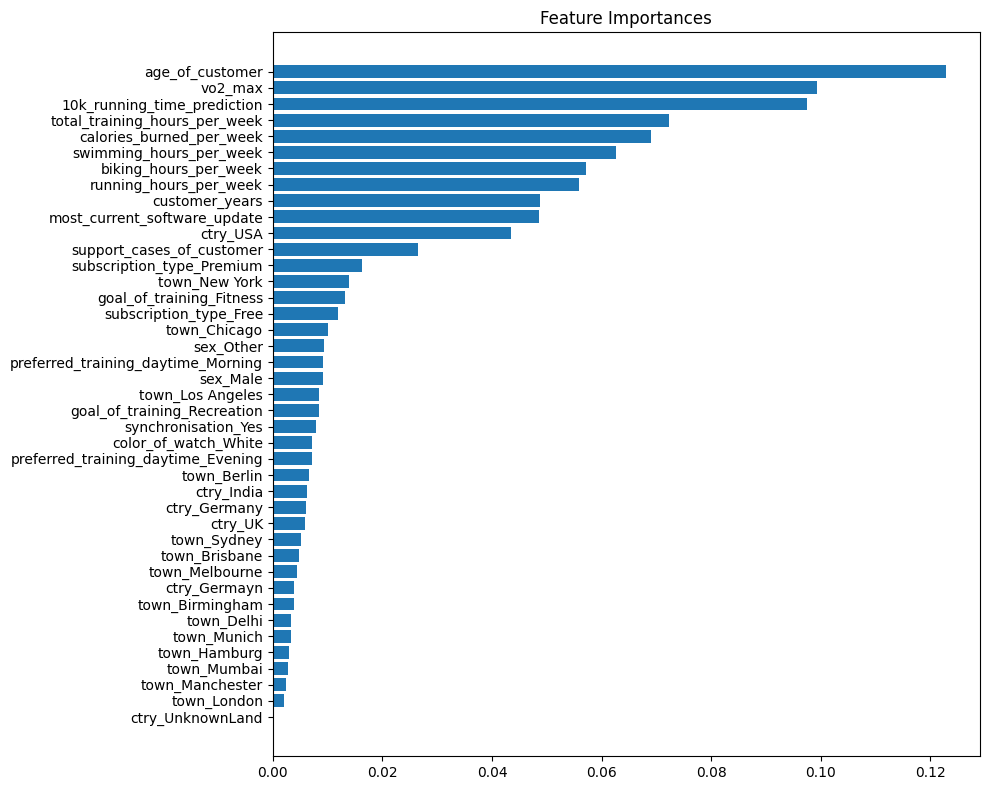

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances Random Forest")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), feature_names[indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7704,0.7202,0.784
0,KNeighborsClassifier,0.590600,0.6888,0.5419,0.672
0,RandomForest,0.722581,0.7500,0.7097,0.766


### BaggingClassifier

In [ ]:
model_name = 'BaggingClassifier'
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)
df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.6751592356687898
Optimized Model F1 Score:  0.7515


### Gradient Boosting Classifier

In [ ]:
model_name = 'GradientBoosting' 
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)
df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.6951219512195121
Optimized Model F1 Score:  0.6988


In [ ]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7704,0.7202,0.784
0,KNeighborsClassifier,0.590600,0.6888,0.5419,0.672
0,RandomForest,0.722581,0.7500,0.7097,0.766
0,BaggingClassifier,0.751500,0.7908,0.6890,0.740
0,GradientBoosting,0.698800,0.7449,0.6857,0.736


### Decision Tree

In [ ]:
model_name = 'DecisionTree'
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)
df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.6190476190476191
Optimized Model F1 Score:  0.686


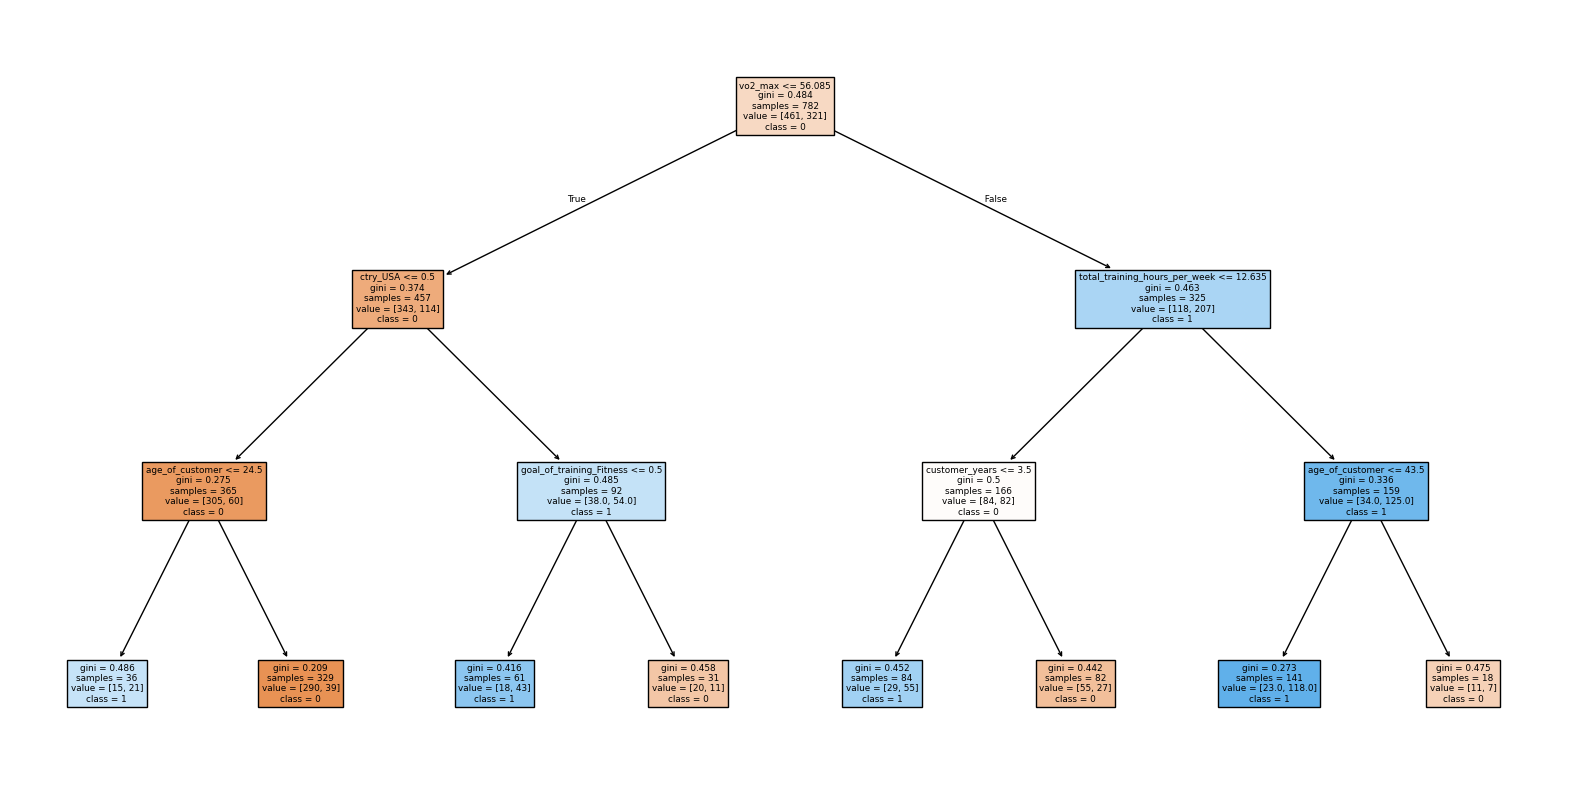

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names, class_names=['0', '1'])
plt.show()

In [15]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7806,0.7202,0.784
0,KNeighborsClassifier,0.575000,0.6531,0.4842,0.608
0,RandomForest,0.722581,0.7704,0.7097,0.766


### AdaBoost

In [16]:
model_name = 'AdaBoost'
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)
df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.6666666666666666
Optimized Model F1 Score:  0.6667


In [17]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7806,0.7202,0.784
0,KNeighborsClassifier,0.575000,0.6531,0.4842,0.608
0,RandomForest,0.722581,0.7704,0.7097,0.766
0,AdaBoost,0.666700,0.7296,0.6700,0.732


### Support Vector Machine Classifier

In [18]:
model_name = 'SVC'
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)
df_results = pd.concat([df_results, df_results_new], axis=0)

F1 Score No Optimization: 0.5
Optimized Model F1 Score:  0.4925
No Optimization has better f1 score than optimized model


In [19]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7806,0.7202,0.784
0,KNeighborsClassifier,0.575000,0.6531,0.4842,0.608
0,RandomForest,0.722581,0.7704,0.7097,0.766
0,AdaBoost,0.666700,0.7296,0.6700,0.732
0,SVC,0.500000,0.6531,0.4641,0.672


### LGBM Classifier

In [20]:
model_name = 'LGBM'
n_opt_trials = 20
df_results_new, model, feature_names = train_test_model(df_train=df_train, 
                                     df_test=df_test, 
                                     model_name=model_name, 
                                     models_func=models_func,
                                     n_opt_trials=n_opt_trials)
df_results = pd.concat([df_results, df_results_new], axis=0)


F1 Score No Optimization: 0.7261904761904762
Best hyperparameters from optuna: {'learning_rate': 0.019834977172791896, 'num_leaves': 238, 'subsample': 0.8322364876020911, 'colsample_bytree': 0.41767280909877746, 'min_data_in_leaf': 31}
Best f1_score from optuna: 0.7421383647798742
Optimized Model F1 Score:  0.7564


<Figure size 1000x800 with 0 Axes>

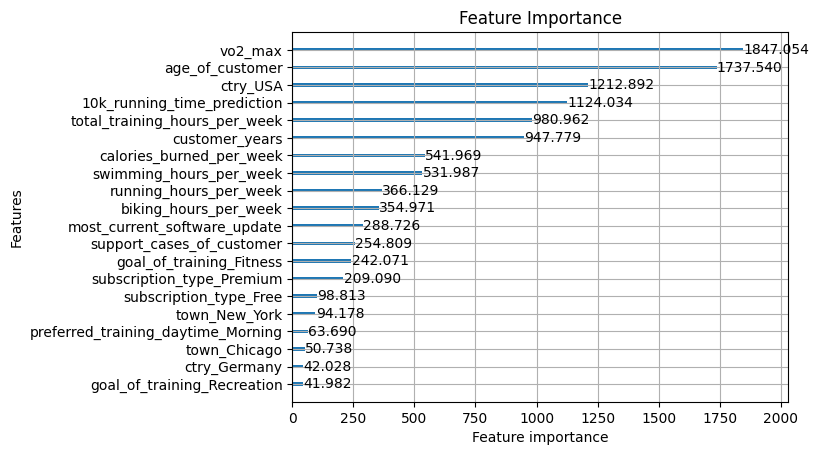

In [ ]:
import lightgbm as lgb

# Plot feature importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Feature Importance LightGBM')
plt.show()

In [125]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7704,0.7202,0.784
0,KNeighborsClassifier,0.590600,0.6888,0.5419,0.672
0,RandomForest,0.722581,0.7500,0.7097,0.766
0,BaggingClassifier,0.751500,0.7908,0.6890,0.740
0,GradientBoosting,0.698800,0.7449,0.6857,0.736
0,DecisionTree,0.686000,0.7245,0.6465,0.696
0,AdaBoost,0.675300,0.7449,0.6615,0.736
0,SVC,0.500000,0.6531,0.4641,0.672
0,LGBM,0.726190,0.7602,0.7019,0.752


### Featur Tokenizer Transformer

Ref: https://arxiv.org/pdf/2106.11959

In order to run the Deep Learning Feature Tokenizer Transformer. Create environment for deep learning:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements_deep_learning.txt
```

Then run the file: 

```bash
python FTT_Tabular_optuna.py
```

In [126]:
import pickle
with open(os.path.join("../../data/processed/ftt_model_results_optuna.pkl"), "rb") as f:
    df_results_new = pickle.load(f)

In [127]:
df_results = pd.concat([df_results, df_results_new], axis=0)

In [130]:
df_results

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy
0,LogisticRegression,0.735484,0.7704,0.7202,0.784
0,KNeighborsClassifier,0.590600,0.6888,0.5419,0.672
0,RandomForest,0.722581,0.7500,0.7097,0.766
0,BaggingClassifier,0.751500,0.7908,0.6890,0.740
0,GradientBoosting,0.698800,0.7449,0.6857,0.736
0,DecisionTree,0.686000,0.7245,0.6465,0.696
0,AdaBoost,0.675300,0.7449,0.6615,0.736
0,SVC,0.500000,0.6531,0.4641,0.672
0,LGBM,0.726190,0.7602,0.7019,0.752
0,FTTabular,0.783100,0.8163,0.7585,0.800


## Results

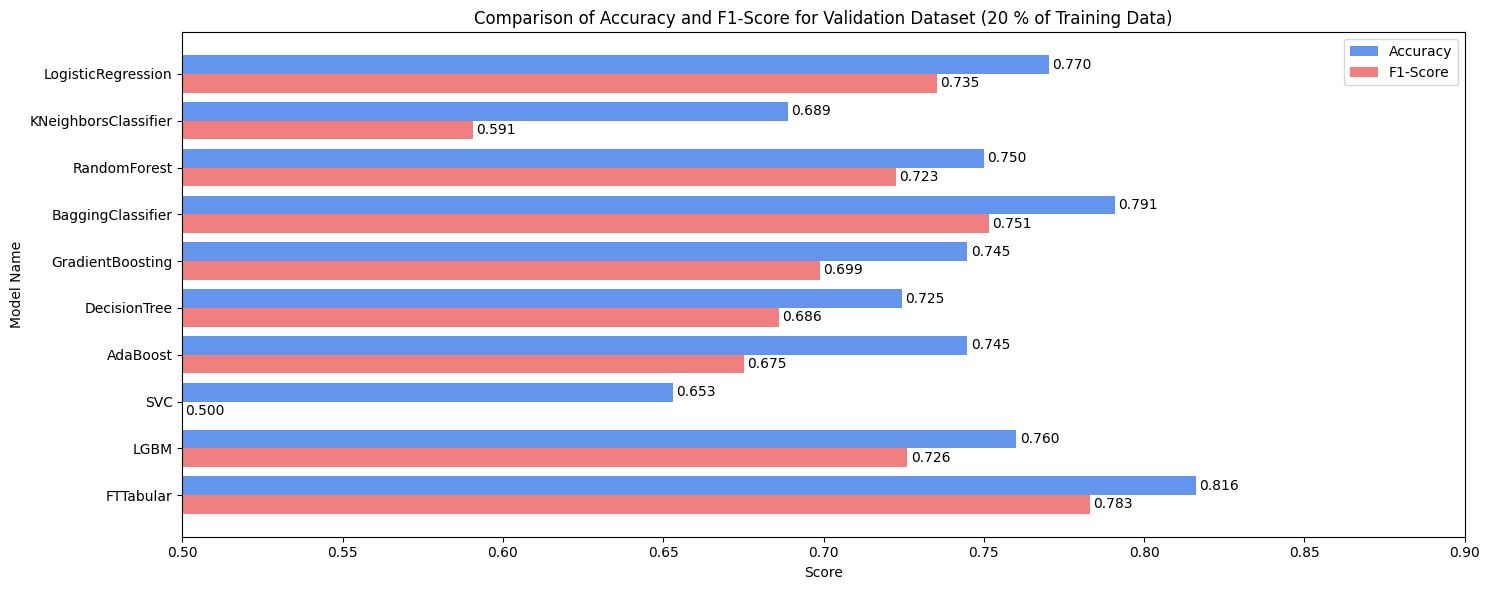

In [131]:
plt.figure(figsize=(15, 6))

bar_height = 0.4
y = range(len(df_results))

# Bars for Accuracy
plt.barh(y, df_results['val_accuracy'], height=bar_height, color='cornflowerblue', label='Accuracy')
for i, value in enumerate(df_results['val_accuracy']):
    plt.text(value + 0.001, i, f'{value:.3f}', va='center', fontsize=10)  # Adds label to Accuracy bars

# Bars for F1-Score (shifted downward)
plt.barh([pos + bar_height for pos in y], df_results['val_f1_score'], height=bar_height, color='lightcoral', label='F1-Score')
for i, value in enumerate(df_results['val_f1_score']):
    plt.text(value + 0.001, i + bar_height, f'{value:.3f}', va='center', fontsize=10)  # Adds label to F1-Score bars

# Customize axis labels and title
plt.ylabel('Model Name')
plt.xlabel('Score')
plt.yticks([pos + bar_height / 2 for pos in y], df_results['Model_Name'])
plt.title('Comparison of Accuracy and F1-Score for Validation Dataset (20 % of Training Data)')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0.5, 0.9) 
plt.tight_layout()
plt.show()

We used for validation dataset 20% of the data from the file **train**. The best performing model in the validation set is FTTabular with an Accuracy of **0.816%** and F1-Score **0.783**. Followed by the LightGBM model with an accuracy of **0.786** and F1-Score of **0.731**. The worst performing model was the Support Vector Classifier. 

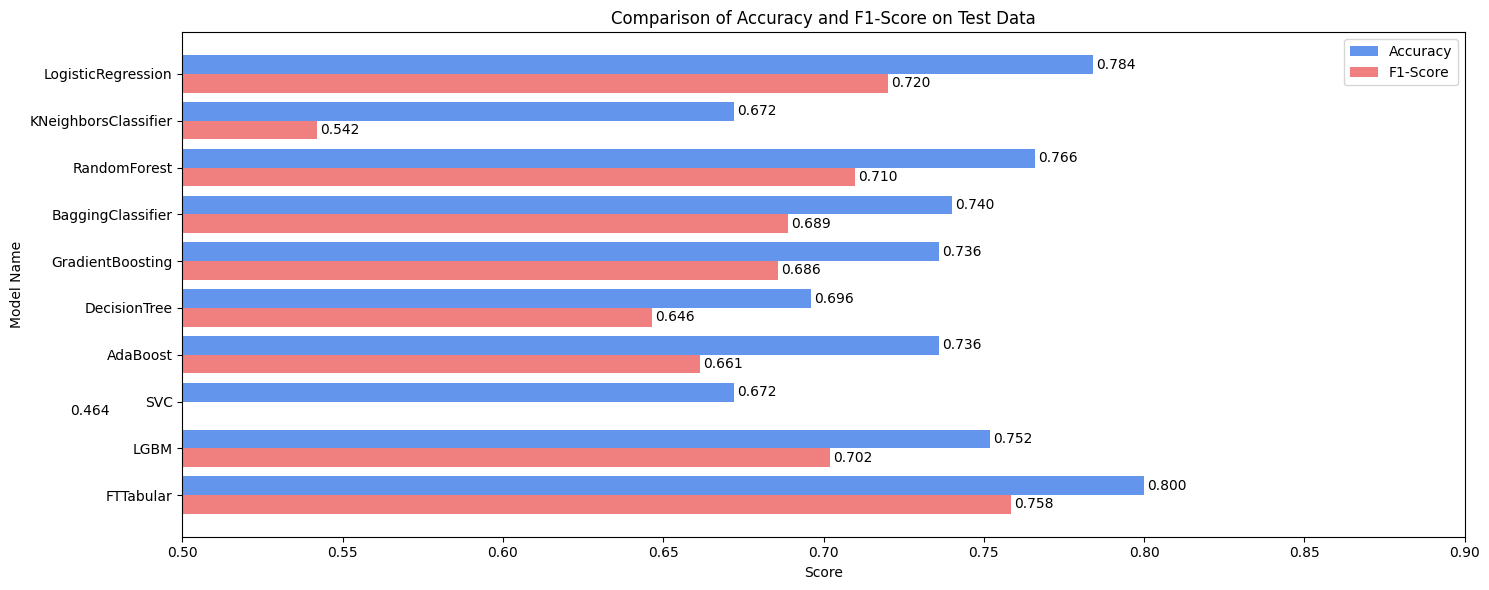

In [132]:
plt.figure(figsize=(15, 6))

bar_height = 0.4
y = range(len(df_results))

# Bars for Accuracy
plt.barh(y, df_results['test_accuracy'], height=bar_height, color='cornflowerblue', label='Accuracy')
for i, value in enumerate(df_results['test_accuracy']):
    plt.text(value + 0.001, i, f'{value:.3f}', va='center', fontsize=10)  # Adds label to Accuracy bars

# Bars for F1-Score (shifted downward)
plt.barh([pos + bar_height for pos in y], df_results['test_f1_score'], height=bar_height, color='lightcoral', label='F1-Score')
for i, value in enumerate(df_results['test_f1_score']):
    plt.text(value + 0.001, i + bar_height, f'{value:.3f}', va='center', fontsize=10)  # Adds label to F1-Score bars

# Customize axis labels and title
plt.ylabel('Model Name')
plt.xlabel('Score')
plt.yticks([pos + bar_height / 2 for pos in y], df_results['Model_Name'])
plt.title('Comparison of Accuracy and F1-Score on Test Data')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0.5, 0.9) 
plt.tight_layout()
plt.show()

For the test data set, the FTTabular again has the highest performance with an accuracy of **0.8** and an F1-Score of **0.758**.

np.float64(0.784)

In [142]:
df_check = df_results.copy()
df_check['Accuracy_baseline_difference'] = df_check['test_accuracy'] - df_check['test_accuracy'].values[0]
df_check['F1-score_baseline_difference'] = df_check['test_f1_score'] - df_check['test_f1_score'].values[0]

In [143]:
df_check

,Model_Name,val_f1_score,val_accuracy,test_f1_score,test_accuracy,Accuracy_baseline_difference,F1-score_baseline_difference
0,LogisticRegression,0.735484,0.7704,0.7202,0.784,0.000,0.0000
0,KNeighborsClassifier,0.590600,0.6888,0.5419,0.672,-0.112,-0.1783
0,RandomForest,0.722581,0.7500,0.7097,0.766,-0.018,-0.0105
0,BaggingClassifier,0.751500,0.7908,0.6890,0.740,-0.044,-0.0312
0,GradientBoosting,0.698800,0.7449,0.6857,0.736,-0.048,-0.0345
0,DecisionTree,0.686000,0.7245,0.6465,0.696,-0.088,-0.0737
0,AdaBoost,0.675300,0.7449,0.6615,0.736,-0.048,-0.0587
0,SVC,0.500000,0.6531,0.4641,0.672,-0.112,-0.2561
0,LGBM,0.726190,0.7602,0.7019,0.752,-0.032,-0.0183
0,FTTabular,0.783100,0.8163,0.7585,0.800,0.016,0.0383


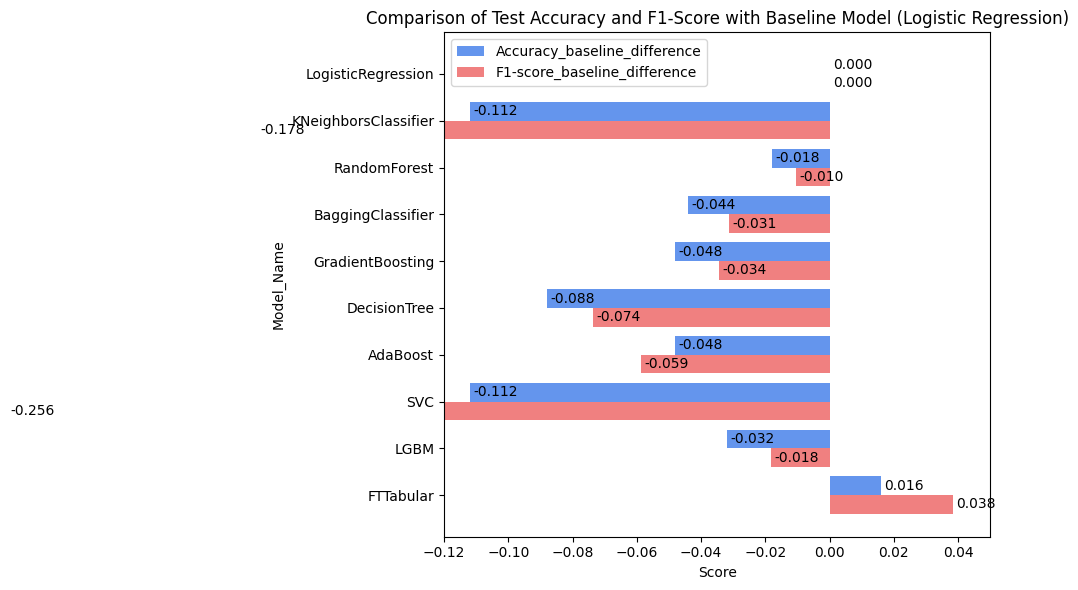

In [148]:
plt.figure(figsize=(15, 6))

bar_height = 0.4
y = range(len(df_check))

# Bars for Accuracy
plt.barh(y, df_check['Accuracy_baseline_difference'], height=bar_height, color='cornflowerblue', label='Accuracy_baseline_difference')
for i, value in enumerate(df_check['Accuracy_baseline_difference']):
    plt.text(value + 0.001, i, f'{value:.3f}', va='center', fontsize=10)  # Adds label to Accuracy bars

# Bars for F1-Score (shifted downward)
plt.barh([pos + bar_height for pos in y], df_check['F1-score_baseline_difference'], height=bar_height, color='lightcoral', label='F1-score_baseline_difference')
for i, value in enumerate(df_check['F1-score_baseline_difference']):
    plt.text(value + 0.001, i + bar_height, f'{value:.3f}', va='center', fontsize=10)  # Adds label to F1-Score bars

# Customize axis labels and title
plt.ylabel('Model_Name')
plt.xlabel('Score')
plt.yticks([pos + bar_height / 2 for pos in y], df_check['Model_Name'])
plt.title('Comparison of Test Accuracy and F1-Score with Baseline Model (Logistic Regression)')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(-0.12, 0.05) 
plt.tight_layout()
plt.show()


